In [1]:
# import relevant libraries for simulation
import matplotlib.pyplot as plt
from random import randint
import scipy.stats as st
import networkx as nx
import numpy as np
import random
import heapq

In [3]:
class Event:
    '''
    Class for creating and handling events
    '''
    def __init__(self, timestamp, function, *args, **kwargs):

        # variables for the timestamp of the event
        self.timestamp = timestamp
        self.function = function
        self.args = args
        self.kwargs = kwargs

    def __lt__(self, other):
        
        '''
        Determining the time-based event schedule
        '''
        
        # determines boolean value to have an event set
        return self.timestamp < other.timestamp

    def run(self, schedule):
        '''
        To run the event given the parameters 
        '''
        # runs the function with params passed
        self.function(schedule, *self.args, **self.kwargs)


class Schedule:
    '''
    Class handling the schedule of the events
    '''
    
    def __init__(self):
        
        # current time
        self.now = 0
        # creating our priority queue
        self.priority_queue = []  
    
    def add_event_at(self, timestamp, function, *args, **kwargs):
        # add event and push to the queue of events
        heapq.heappush(self.priority_queue, Event(timestamp, function, *args, **kwargs))
    
    def add_event_after(self, interval, function, *args, **kwargs):
        
        # adding the subsequent event
        self.add_event_at(self.now + interval, function, *args, **kwargs)
    
    def next_event_time(self):
        
        # next event in the queue
        return self.priority_queue[0].timestamp
 
    def run_next_event(self):
        
        # running the following event
        event = heapq.heappop(self.priority_queue)
        self.now = event.timestamp
        event.run(self)
        
    def __repr__(self):
        return 

In [4]:
def create_NCR():
    """
    This function creates the NCR set-up to a network structure. 
    It returns the network with the respectively connected nodes 
    """

    NCR = nx.Graph() 

    NCR.add_edge("Powell", "Union Sq", weight = 3)
    NCR.add_edge("Powell", "Civic Center", weight = 3)
    NCR.add_edge("Powell", "Embarcadero", weight = 5)
    NCR.add_edge("Powell", "Soma", weight = 4)

    NCR.add_edge("Union Sq", "Lower Nob Hill", weight = 4)
    NCR.add_edge("Union Sq", "North Beach", weight = 3)

    NCR.add_edge("Civic Center", "Van Ness", weight = 3)
    NCR.add_edge("Civic Center", "Lower Nob Hill", weight = 3)

    NCR.add_edge("Lower Nob Hill", "Russian Hill", weight = 2) 
    NCR.add_edge("Lower Nob Hill", "Van Ness", weight = 2.5) 

    NCR.add_edge("Embarcadero", "North Beach", weight = 3.5)
    NCR.add_edge("Embarcadero", "Soma", weight = 2)
    

    NCR.add_edge("North Beach", "Russian Hill", weight = 2)

    NCR.add_edge("Van Ness", "Mission", weight = 3)
    NCR.add_edge("Van Ness", "Soma", weight = 1.5) 

    
    # Scaling to 20 for better interpretation in graphing and timing 
    # We are going to deal with minutes here 
    for u,v,d in NCR.edges(data = True):
        d['weight'] *= 20

    return NCR 

In [5]:
NCR = create_NCR()
pos = nx.kamada_kawai_layout(NCR)

NCR Layout overview


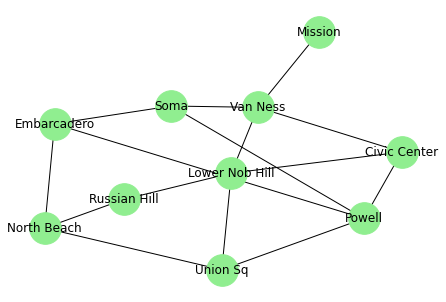

In [6]:
print("NCR Layout overview")
nx.draw(NCR, pos = pos, with_labels = True, node_color = 'lightgreen', node_size = 1000)

In [7]:
print("Network stats:")
print("----")
print('Edges:', len(NCR.edges()))
print("Nodes:", len(NCR.nodes()))

Network stats:
----
Edges: 15
Nodes: 10


In [2]:
def find_weights(f_node, s_node):
    """
    calculates the weights between first and last node
    """
    # takes the weight to be from the assigned value of the nodes
    return garbage_spots[f_node] + garbage_spots[s_node]

def waste_production_rate(c_node):
    """
    Defining waste as a function of the population
    """
    # 
    waste_production = 0.3
    
    # waste produced related to population at nodes (increases/decreases based on population) 
    waste_produced = (node_population[c_node]/1000) * waste_production
    
    return 100/waste_produced

def dump_location(network, no_sites):
    """    
    Choosing a random drop off location
    """
    distribution = {}    
    nodes = list(network.nodes())    
    for i in range(no_sites):
        position = random.choice(nodes) # random choice
        nodes.remove(position)
        distribution[position] = True # establishes it as the dump
    for i in range(len(nodes)):
        position = random.choice(nodes)
        nodes.remove(position)
        distribution[position] = False #
    return distribution

In [21]:
class WasteSystem: 
    """
    The main class of our waste removal network
    """
    
    def __init__(self, network):

        # Complete network
        self.network = network 
        self.waste_collection_time = [] 
        self.waste_to_collect = 0
        self.collection_time_prior = 30  # based on average time to get between two nodes in the system of SF
        self.collection_time_std = 5     # Standard Deviation

        # Fuel Aspect, total capacity is 90 gallons - as described by online sources
        self.fuel = []
        self.capacity = 90 

        # introducing randomness to our MC simulation
        self.additional_time_mean = 20
        self.additional_time_std = 5
        self.probabilistic_randomness = 70   # 50%, so half the time we need more time than usual

        # the waste truck might have to drive to another farm
        self.collection_sites = []
        self.drop_off_site = []
        self.drop_off_available = []

        # checks if there is a site available for dumping
        for existing_node in nodes_in_system.nodes():
            if self.network.nodes[existing_node]['waste_truck']:
                self.drop_off_site.append(existing_node)

    def schedule_waste_collection(self, schedule, last_node):
          """
          Determines the time for the next waste collection that is needed
          """
          self.order_waste_collection(schedule, last_node)
          schedule.add_event_after(np.random.normal(self.network.nodes[last_node]["waste_rate"], 2) + random.random(), self.schedule_waste_collection, last_node)

    def order_waste_collection(self, schedule, last_node): 
        """
        Ordering the collection of waste and setting it up
        """

      # check to see if there is a drop-off site available
        if len(self.drop_off_site) != 0:
            # sentinels
            min_length = float("inf")
            min_length_site = None

            for site in self.drop_off_site:
                length = nx.shortest_path_length(self.network, source = site, 
                                                 target = last_node, 
                                                 weight = 'weight')
                if length < min_length:
                    min_length = length
                    min_length_site = site
            
            # schedule an event
            schedule.add_event_after(0, self.start_collection, 
                                     first_node = min_length_site, 
                                     last_node = last_node)
        else: 

            # add the site to the queue
            self.collection_sites.append(last_node)

    def time_of_arrival(self, first_node, last_node):
            """
            Finding the total distance back-and forth between nodes
            """
            distance = nx.shortest_path_length(self.network, source = first_node,
                                              target = last_node, weight = 'weight')
            
            return distance * 2
    
    def start_collection(self, schedule, first_node, last_node):
        """
        Beginning our waste collection process
        """
        
        # increasing counter for nodes where trash is to be collected 
        self.waste_to_collect += 1

        # this node cannot be a drop-off
        try:
            self.drop_off_site.remove(first_node)
        except ValueError:
            pass

        self.network.nodes[first_node]['waste_truck'] = False
        
        # initializing addtional time
        random_time = 0

        # comparing against random value to see
        if randint(0, 100) <= self.probabilistic_randomness:
            
            # determine additional time from normally distributed values
            random_time = np.random.normal(self.additional_time_mean, self.additional_time_std)

        # collection time is total time needed to collect
        collection_time = np.random.normal(self.collection_time_prior, self.collection_time_std)
        calculated_time_of_arrival = self.time_of_arrival(first_node, last_node)*2 
        total_collection_time = calculated_time_of_arrival + collection_time + random_time
        self.waste_collection_time.append(self.time_of_arrival(first_node, last_node)*2)

        # Fuel calculation is also done using online sources
        self.fuel.append(self.capacity - (self.time_of_arrival(first_node, last_node)*2.5))
        
        # schedule event to be added
        schedule.add_event_after(total_collection_time, self.finish_waste_collection, first_node)
        
    def finish_waste_collection(self, schedule, initial_node): 
        """
        Finishing the removal process
        """

        # Tagging our drop off
        self.network.nodes[initial_node]['waste_truck'] = True
        self.drop_off_site.append(initial_node)
        self.drop_off_available.append(len(self.drop_off_site))
        
        # checking to see if more nodes can be visited
        if len(self.collection_sites) > 0:
            schedule.add_event_after(0, self.start_collection, 
                                     first_node = initial_node, 
                                     last_node = self.collection_sites.pop())
 
        
    def start_simulation(self, schedule):
            """
            Starts the simulation with an initial waste collection
            """
            for existing_node in self.network.nodes():
                time = np.random.poisson(self.network.nodes[existing_node]["waste_rate"])
                schedule.add_event_after(time + random.random(), self.schedule_waste_collection, existing_node)

In [22]:
def run_waste_simulation(network, run_until = 100): 
    """
    Running the simulation with the given parameters
    """
    # instantiating the classes 
    schedule = Schedule()
    waste_collection_process = WasteSystem(network)
    waste_collection_process.start_simulation(schedule)
    
    # running simulation
    while schedule.next_event_time() < run_until:
        schedule.run_next_event()

    return waste_collection_process

In [23]:
c = ["powell", "union square", "soma", "embarcadero", 
                  "north beach", "lower nob hill", "russian hill", 
                  "civic center", "mission", "van ness"]

# assigned values to the nodes in the network
garbage_spots = {"powell": 1.5, "union square": 1.95,
                   "soma": 0.92, "embarcadero": 2.22,
                   "north beach": 1.49, "lower nob hill": 2.24,
                   "russian hill": 0.87, "civic center": 1.29,
                   "mission": 0.70, "van ness": 1.86}

node_population = {"powell": 15000, "union square": 40000,
                   "soma": 7500, "embarcadero": 50000,
                   "north beach": 14200, "lower nob hill": 62500,
                   "russian hill": 6300, "civic center": 14650,
                   "mission": 5000, "van ness": 19624}


connected_nodes = [["powell", "union square"], ["powell", "soma"],
                   ["powell", "lower nob hill"], ["powell", "civic center"],
                   ["civic center", "lower nob hill"], ["civic center", "soma"], 
                   ["van ness", "civic center"], ["van ness", "soma"],
                   ["van ness", "lower nob hill"], ["soma", "embarcadero"],
                   ["embarcadero", "lower nob hill"], ["embarcadero", "north beach"],
                   ["lower nob hill", "van ness"],["north beach", "russian hill"], \
                   ["north beach", "union square"],
                   ["russian hill", "lower nob hill"], ["union square", "lower nob hill"],
                   ["van ness", "mission"]]

# test that simulation runs as expected
nodes_in_system = nx.Graph()

for edge in connected_nodes:
    nodes_in_system.add_edge(edge[0], edge[1], weight = find_weights(edge[0], edge[1]))

# determines drop-off sites
dis = dump_location(nodes_in_system, 6)

for node in nodes_in_system.nodes():
    nodes_in_system.nodes[node]['population'] = node_population[node]
    nodes_in_system.nodes[node]['area'] = garbage_spots[node]
    nodes_in_system.nodes[node]['waste_rate'] = waste_production_rate(node)
    nodes_in_system.nodes[node]['waste_truck'] = dis[node]
            
run_waste_simulation(nodes_in_system, run_until = 100)

In [24]:
print(out.collection_sites)

['lower nob hill', 'van ness', 'embarcadero', 'lower nob hill', 'union square', 'civic center', 'powell', 'lower nob hill', 'north beach', 'embarcadero', 'union square', 'lower nob hill', 'van ness', 'lower nob hill', 'soma', 'union square', 'embarcadero', 'lower nob hill', 'embarcadero', 'powell', 'civic center', 'union square', 'lower nob hill', 'north beach', 'van ness', 'embarcadero', 'russian hill', 'lower nob hill', 'mission', 'embarcadero', 'lower nob hill', 'union square', 'lower nob hill', 'van ness', 'powell', 'civic center', 'embarcadero', 'union square', 'north beach', 'lower nob hill', 'embarcadero', 'lower nob hill', 'union square', 'embarcadero', 'soma', 'van ness', 'lower nob hill', 'civic center', 'powell', 'embarcadero', 'union square', 'lower nob hill', 'north beach', 'embarcadero', 'embarcadero', 'union square', 'lower nob hill', 'van ness', 'embarcadero', 'union square', 'russian hill', 'embarcadero', 'civic center', 'lower nob hill', 'powell', 'lower nob hill', 'u

In [47]:
# initialize values of interest on the simulation
average_service_time = []
average_queue_len=[]
best_number_of_stations = 3
average_fuel_remaining = []
# loops to represent the numerous trials
for i in range(1000):
    
    # reset the network
    nodes_in_system = nx.Graph()
    for edge in connected_nodes:
        nodes_in_system.add_edge(edge[0], edge[1], weight = find_weights(edge[0], edge[1]))
    
    # get a random distribution for the stations
    
    dis = dump_location(nodes_in_system, best_number_of_stations)
    
    for node in nodes_in_system.nodes():
        nodes_in_system.nodes[node]['population'] = node_population[node]
        nodes_in_system.nodes[node]['area'] = garbage_spots[node]
        nodes_in_system.nodes[node]['waste_rate'] = waste_production_rate(node)
        nodes_in_system.nodes[node]['waste_truck'] = dis[node]
        
    # save the output variables
    out = run_waste_simulation(nodes_in_system, run_until=1000)
    average_service_time.append(np.mean(out.waste_collection_time))
   # average_queue_len.append(np.mean(out.length_of_queue))
    average_fuel_remaining.append(np.mean(out.fuel))

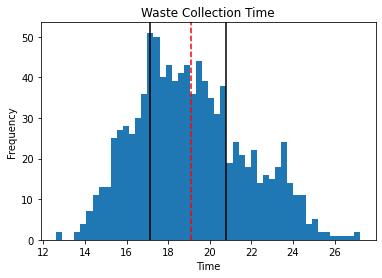

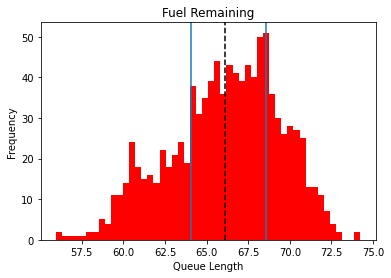

Average time needed for the average strategy: 19.097432867418494
Average time needed 95% confidence interval (18.989848555017243, 19.205017179819745)
Average queue length: nan


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [48]:
confint = st.t.interval(alpha = 0.8, df = len(average_fuel_remaining) - 1, loc = np.mean(average_fuel_remaining), scale = st.sem(average_fuel_remaining))
mean_fuel = np.mean(average_fuel_remaining)
mean_time = np.mean(average_service_time)
per_1 = np.percentile(average_fuel_remaining, 25)
per_2 = np.percentile(average_fuel_remaining, 75)

perc_1 = np.percentile(average_service_time, 25)
perc_2 = np.percentile(average_service_time, 75)

# plot the results and get the confidence interval
plt.hist(average_service_time, bins = 50)
plt.title("Waste Collection Time")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.axvline(mean_time, color = "red", linestyle = '--')
plt.axvline(perc_1, color="black")
plt.axvline(perc_2, color= "black")
plt.show()

plt.hist(average_fuel_remaining, bins = 50, color = 'red')
plt.title("Fuel Remaining")
plt.xlabel('Queue Length')
plt.ylabel('Frequency')
plt.axvline(mean_fuel, color = "black", linestyle = '--')
plt.axvline(per_1)
plt.axvline(per_2)
plt.show()


print(f"Average time needed for the average strategy: {np.mean(average_service_time)}")
print(f"Average time needed 95% confidence interval {st.t.interval(alpha = 0.8, df = len(average_service_time) - 1, loc = np.mean(average_service_time), scale = st.sem(average_service_time)) }")
print(f"Average queue length: {np.mean(average_queue_len)}")
#print(f"Average queue length 95% confidence interval {st.t.interval(alpha = 0.8, df = len(average_queue_len) - 1, loc = np.mean(average_queue_len), scale = st.sem(average_queue_len)) }")

In [27]:
# find the nodes with highest degree considering weights
order = sorted(nodes_in_system.degree(weight = "weight"), key = lambda x: x[1], reverse = True)
best_distribution = {}
nodes = list(nodes_in_system.nodes())

for i in range(best_number_of_stations):
    spot = order[i][0]
    nodes.remove(spot)
    best_distribution[spot] = True
    
for node in nodes:
    best_distribution[node] = False# ini

In [32]:
average_service_time = []
average_queue_len = []
average_fuel_remaining= []

# run the simulation for 1000 trials
for i in range(1000):
    
    # reset the network with the best distribution
    nodes_in_system = nx.Graph()
    
    for edge in connected_nodes:
        nodes_in_system.add_edge(edge[0], edge[1], weight=find_weights(edge[0], edge[1]))
        
    for node in nodes_in_system.nodes():
        nodes_in_system.nodes[node]['population'] = node_population[node]
        nodes_in_system.nodes[node]['area'] = garbage_spots[node]
        nodes_in_system.nodes[node]['waste_rate'] = waste_production_rate(node)
        nodes_in_system.nodes[node]['waste_truck'] = best_distribution[node]

    # save the results
    out = run_waste_simulation(nodes_in_system, run_until=100)
    average_service_time.append(np.mean(out.waste_collection_time))
    #average_queue_len.append(np.mean(out.length_of_queue))
    average_fuel_remaining.append(np.mean(out.fuel))


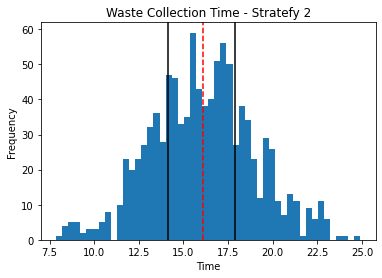

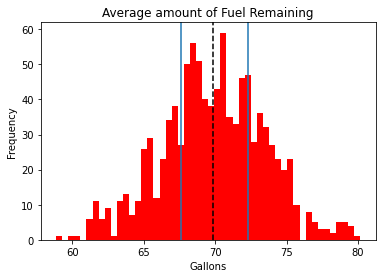

Average time needed for the average strategy: 16.095014301587305
Average time needed 95% confidence interval (15.977607300164337, 16.212421303010274)
Average amount of fuel left: 69.88123212301588
Average fuel remaining 95% confidence interval (69.73447337123717, 70.02799087479458)


In [46]:
confint = st.t.interval(alpha = 0.8, df = len(average_fuel_remaining) - 1, loc = np.mean(average_fuel_remaining), scale = st.sem(average_fuel_remaining))
mean_fuel = np.mean(average_fuel_remaining)
mean_time = np.mean(average_service_time)
per_1 = np.percentile(average_fuel_remaining, 25)
per_2 = np.percentile(average_fuel_remaining, 75)

perc_1 = np.percentile(average_service_time, 25)
perc_2 = np.percentile(average_service_time, 75)

# plot the results and get the confidence interval
plt.hist(average_service_time, bins = 50)
plt.title("Waste Collection Time - Stratefy 2")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.axvline(mean_time, color = "red", linestyle = '--')
plt.axvline(perc_1, color="black")
plt.axvline(perc_2, color= "black")
plt.show()



plt.hist(average_fuel_remaining, bins = 50, color = 'red')
plt.title("Average amount of Fuel Remaining")
plt.xlabel('Gallons')
plt.ylabel('Frequency')
plt.axvline(mean_fuel, color = "black", linestyle = '--')
plt.axvline(per_1)
plt.axvline(per_2)
plt.show()

confint = st.t.interval(alpha = 0.8, df = len(average_fuel_remaining) - 1, loc = np.mean(average_fuel_remaining), scale = st.sem(average_fuel_remaining))


print(f"Average time needed for the average strategy: {np.mean(average_service_time)}")
print(f"Average time needed 95% confidence interval {st.t.interval(alpha = 0.8, df = len(average_service_time) - 1, loc = np.mean(average_service_time), scale = st.sem(average_service_time)) }")
print(f"Average amount of fuel left: {np.mean(average_fuel_remaining)}")
print(f"Average fuel remaining 95% confidence interval {st.t.interval(alpha = 0.8, df = len(average_fuel_remaining) - 1, loc = np.mean(average_fuel_remaining), scale = st.sem(average_fuel_remaining)) }")